### Evaluating expected entropy

In [2]:
from dredFISH.Analysis import TissueGraph as tg
from dredFISH.Visualization.utils import  get_aggregate_counts, avg_dend, cut_dend
from dredFISH.Visualization.cell_colors import colors_from_list
from dredFISH.Visualization.vor import bounding_box_grid

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.collections import LineCollection

from copy import copy
from collections import Counter

%load_ext line_profiler


### Load data

In [2]:
dpath="/home/jperrie/Documents/max_biocart/AllenDendrogramAsTable.csv" 
mpath="/home/jperrie/Documents/max_biocart/HippocampusCellTypeCalls.csv"
meta=pd.read_csv(mpath,index_col=0)
XY = meta[["x_coordinate","y_coordinate"]].values
XY[:,1]=-XY[:,1]

In [3]:
TG = tg.TissueGraph()
TG = TG.BuildSpatialGraph(XY)
TG.Type=cell_label=meta["cell_type_low"]

In [1]:
fig,ax=plt.subplots(figsize=(8,6))

segments, bb = bounding_box_grid(TG.XY, scale=25, padding=10, threshold=50, sd=0.1, nofill=False)
ax.add_collection(LineCollection(segments,
                                 colors="red",
                                 lw=3,
                                 alpha=0.8,
                                 linestyle='solid'))
ax.scatter(x=TG.X,y=TG.y,c="black",s=1,alpha=0.8)
plt.show()


NameError: name 'plt' is not defined

### Allen dend-cut and find optimal types

In [5]:
dend=pd.read_csv(dpath,index_col=0)
dend=dend.loc[dend["H"]>0]
dend.sort_values(by="H",inplace=True)
dend.set_index(np.arange(len(dend)))
dend["A"]=dend["A"].astype(str)
dend["B"]=dend["B"].astype(str)
dend["C"]=dend["C"].astype(str)

In [6]:
# dendrogram colors
fpath = "/home/rlittman/JSTA_classified_celltypes/data/hippocampus.merfish.jsta.segmented.counts.csv.gz"
counts = get_aggregate_counts(fpath)  
dend_counts = avg_dend(dend, counts)

In [7]:
PossType = cut_dend(dend,np.array(TG.Type),0.125)
%lprun -T lprof0 -f TG.ContractGraph TG.ContractGraph(PossType)


*** Profile printout saved to text file 'lprof0'. 


Timer unit: 1e-06 s

Total time: 0.039536 s
File: /home/jperrie/Documents/dredFISH/dredFISH/Analysis/TissueGraph.py
Function: ContractGraph at line 468

Line #      Hits         Time  Per Hit   % Time  Line Contents
   468                                               def ContractGraph(self,TypeVec = None):
   469                                                   """ContractGraph : reduce graph size by merging neighbors of same type. 
   470                                                       Given a vector of types, will contract the graph to merge vertices that are 
   471                                                       both next to each other and of the same type. 
   472                                                   
   473                                                   Input: TypeVec - a vector of Types for each node. 
   474                                                          If TypeVec is not provided will attempty to use the Type property of the graph itself

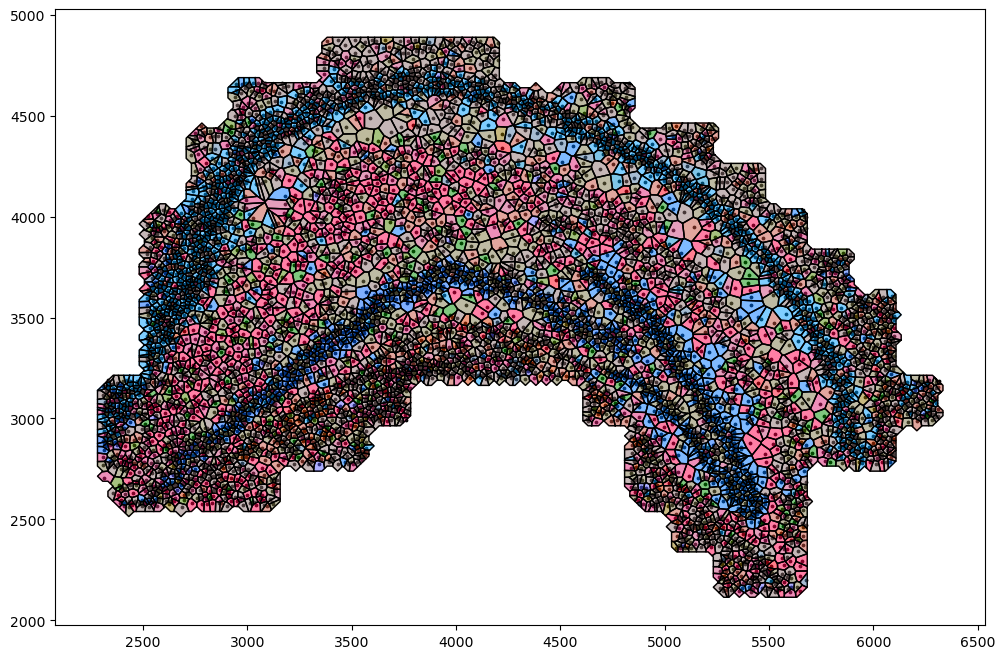

In [8]:
color_dict = colors_from_list(dend_counts.index, copy(dend_counts), lum=50)
TG.plot(cell_type=PossType, color_dict=color_dict, graph_params={"scatter":True})
plt.show()

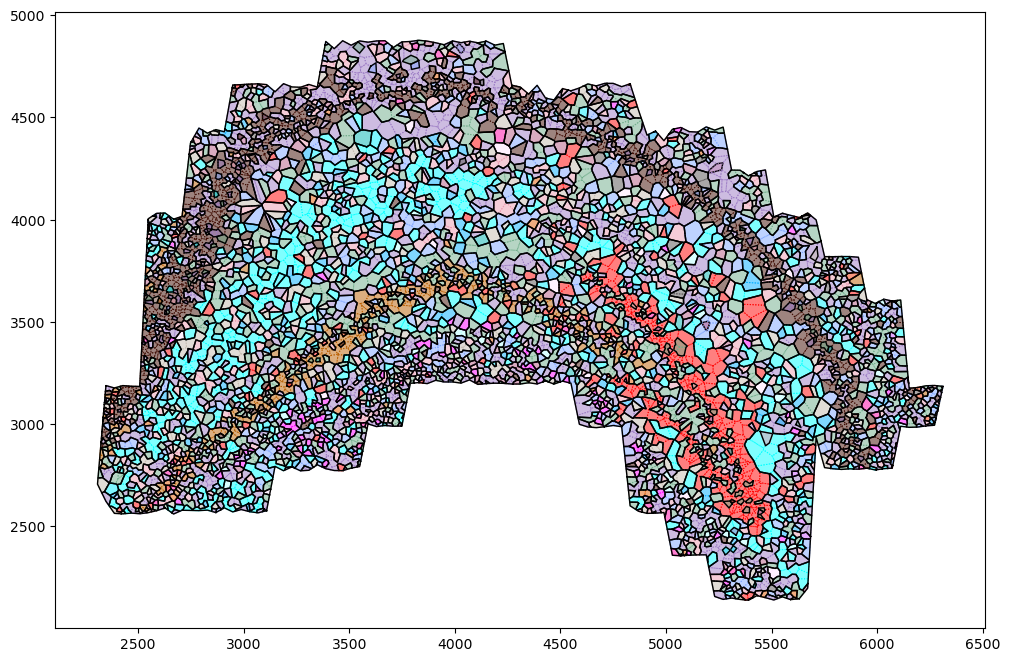

In [13]:
color_dict = colors_from_list(dend_counts.index, copy(dend_counts), rot=45, axis=1)
CG=TG.ContractGraph(PossType)
# pass in cell level coordinates (XY) and cell type (cell_type) otherwise things will crash
CG.plot(XY=TG.XY,cell_type=PossType,color_dict=color_dict, graph_params={"inner":True})
plt.show()

In [26]:
Hvec=dend["H"].values
Sz = np.empty(len(Hvec))
CondEnt = np.empty(len(Hvec))
AllZones = list()
for i in range(len(Hvec)):
    if i % 25 == 0:
        print(i)
    PossType = dend_cut(dend,TG.Type,Hvec[i])
    Sz[i]=len(set(PossType))
    AllZones.append(TG.ContractGraph(PossType))
    CondEnt[i] = AllZones[i].CondEntropy()
print("done")

0
25
50
75
100
125
150
175
200
225
250
275
done


### conditional entropy corrected similar to adjusted mutual information 
adj(H(Y|X))=\[H(Y|X)-E(H(Y|X))\]/\[max(H(Y),H(X))-E(H(Y|X))\]

In [ ]:
from scipy.stats import entropy 
ehx=np.array([entropy(np.array([1/AllZones[i].Ntypes for j in range(AllZones[i].Ntypes)]),base=2) for i in range(len(AllZones))])
ehy=np.array([entropy(np.array([1/len(AllZones[i].NodeSize) for j in range(len(AllZones[i].NodeSize))]),base=2) for i in range(len(AllZones))])

In [ ]:
from collections import Counter
hy=np.array([entropy(AllZones[i].NodeSize/sum(AllZones[i].NodeSize),base=2) for i in range(len(AllZones))])
hx=np.array([entropy(AllZones[i].TypeFreq()[0],base=2) for i in range(len(AllZones))])

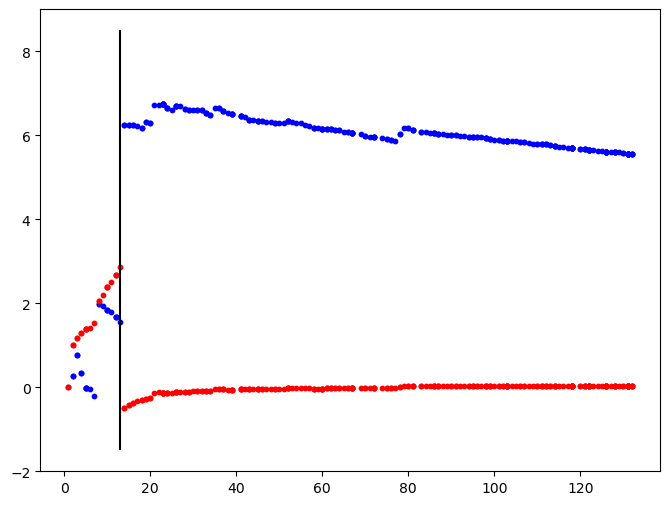

In [ ]:
fig,ax=plt.subplots(figsize=(8,6))
plt.scatter(x=Sz,y=CondEnt,s=10,c="blue")
plt.scatter(x=Sz,y=(CondEnt+ehx-ehy+1E-20)/(np.max([hx,hy],0)+ehx-ehy+1E-10),s=10,c="red")
plt.vlines(x=Sz[np.argmax((CondEnt+ehx-ehy+1E-20)/(np.max([hx,hy],0)+ehx-ehy+1E-20))],ymin=-1.5,ymax=8.5,colors="black")
plt.show()

In [11]:
KL([0.1,0.4,0.5],[0.333,0.333,0.333])

array([-0.12029723,  0.07332882,  0.2032328 ])

In [13]:
TG.G.vs

In [23]:
g = Graph([(0,1), (0,2), (2,3), (3,4), (4,2), (2,5), (5,0), (6,3), (5,6)])
g.vs["age"] = np.asarray([[25,17], 31, 18, 47, 22, 23, 50],dtype=object)

In [24]:
g.vs["age"]

[[25, 17], 31, 18, 47, 22, 23, 50]

In [49]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=500, algorithm='auto').fit(TG.XY)

In [50]:
distances, indices = nbrs.kneighbors(TG.XY)

In [51]:
avgdst = np.mean(distances,axis=0)
avgsz = np.arange(nbrs.n_neighbors)    


(500,)
(500,)


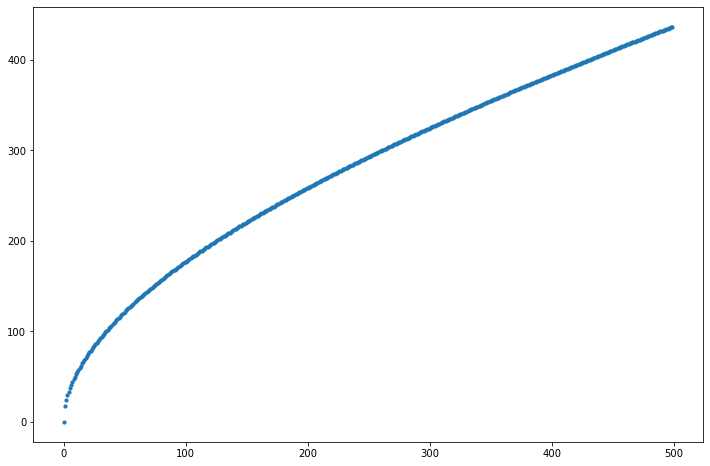

In [52]:
fig,ax=plt.subplots(figsize=(12,8))
plt.scatter(x=avgsz,y=avgdst,s=10)

In [61]:
def funcKL(P,Q): 
    ix = P>0
    return(np.sum(P[ix]*np.log2(P[ix]/Q[ix])))

def funcJSD(P,Q):
    M=0.5*P + 0.5*Q
    return(0.5*funcKL(P,M) + 0.5*funcKL(Q,M))


In [54]:
iter=10
TypeVec = TG.Type
Rnd = np.reshape(np.random.choice(TG.Type, size=iter * nbrs.n_neighbors, replace=True),(iter,nbrs.n_neighbors))
for i in range(nbrs.n_neighbors): 
    unq,cnt = np.unique(Rnd[0,

In [81]:
nbrs = NearestNeighbors(n_neighbors=1000, algorithm='auto').fit(TG.XY)
distances, indices = nbrs.kneighbors(TG.XY)
distances.shape

(6958, 1000)

In [90]:
unqTypes = np.unique(TG.Type) 
cntdict = CountValues(TG.Type[0:9],unqTypes)
Ptypes = np.array([cntdict.get(k) for k in sorted(cntdict.keys())])
Ptypes

array([0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [98]:
def my_func(a):
    """Average first and last element of a 1-D array"""
    return [1, (a[0] + a[-1]) * 0.5]
b = np.array([[1,2,3], [4,5,6], [7,8,9]])
print(b)
np.apply_along_axis(my_func, 1, b)

[[1 2 3]
 [4 5 6]
 [7 8 9]]


array([[1., 2.],
       [1., 5.],
       [1., 8.]])

In [84]:
def CountValues(V,refvals):
    Cnt = Counter(V)
    cntdict = dict(Cnt)
    missing = list(set(refvals) - set(V))
    cntdict.update(zip(missing, np.zeros(len(missing))))
    return(cntdict)
    
TypeVec = TG.Type
cntdict = CountValues(TypeVec[0:9],np.unique(TypeVec))
sorted(cntdict)


['Astro_1',
 'Astro_2',
 'CA1sp/SUB-sp Kcnip1_1',
 'CA1sp/SUB-sp Kcnip1_2',
 'CA1sp/SUB-sp Kcnip1_3',
 'CA1sp_1',
 'CA1sp_10',
 'CA1sp_2',
 'CA1sp_3',
 'CA1sp_4',
 'CA1sp_5',
 'CA1sp_6',
 'CA1sp_7',
 'CA1sp_8',
 'CA1sp_9',
 'CA2sp/IG',
 'CA3sp_1',
 'CA3sp_2',
 'CA3sp_3',
 'CA3sp_4',
 'CA3sp_5',
 'CA3sp_6',
 'CA3sp_7',
 'DG_1',
 'DG_2',
 'DG_3',
 'IT RHP Dcn_1',
 'IT RHP Dcn_2',
 'IT RHP Dcn_3',
 'IT RHP Dcn_4',
 'IT RHP Dcn_5',
 'Lamp5 Lhx6_1',
 'Lamp5 Lhx6_2',
 'Lamp5 Lhx6_3',
 'Lamp5 Lhx6_4',
 'Lamp5 Lhx6_5',
 'Lamp5_1',
 'Lamp5_2',
 'Lamp5_3',
 'Lamp5_4',
 'Lamp5_5',
 'Lamp5_6',
 'Macrophage_1',
 'Macrophage_2',
 'Oligo_1',
 'Oligo_2',
 'Oligo_3',
 'Oligo_4',
 'Oligo_5',
 'PIR Six3',
 'Pvalb_1',
 'Pvalb_10',
 'Pvalb_11',
 'Pvalb_12',
 'Pvalb_2',
 'Pvalb_3',
 'Pvalb_4',
 'Pvalb_5',
 'Pvalb_6',
 'Pvalb_7',
 'Pvalb_8',
 'Pvalb_9',
 'SUB-Sp Ndst4_1',
 'SUB-Sp Ndst4_2',
 'SUB-Sp Ndst4_3',
 'SUB-Sp Ndst4_4',
 'SUB-Sp Ndst4_5',
 'Serpinf1_1',
 'Serpinf1_2',
 'Serpinf1_3',
 'Sncg/Ndnf HPF_1

In [75]:
Cnt

Counter({'Sst_1': 1,
         'Lamp5 Lhx6_4': 1,
         'Sst_13': 1,
         'Vip_2': 1,
         'CA1sp/SUB-sp Kcnip1_2': 1,
         'CA1sp_9': 1,
         'CA1sp_10': 2,
         'DG_2': 1})